In [1]:
import os                       # for working with files
import pandas as pd             # Kiểu dữ liệu dataframe
import random                   
import time                     
from tqdm import tqdm           

import torch                    # Pytorch module 
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders: chia dữ liệu thành các batch
from torchvision import datasets,transforms,models   # for working with classes and images
from torch.optim import lr_scheduler #giảm tốc độ học theo thời gian
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import matplotlib.image as mpimg
from tempfile import TemporaryDirectory 

writer_train = SummaryWriter('runs/vgg19_SGD_Pretrain/train')
writer_test = SummaryWriter('runs/vgg19_SGD_No-Pretrain/test')


1 xử lý và đánh giá dataset

In [2]:
data_dir = "C:\code\Project_TTKH\Data"
train_dir = os.path.join(data_dir,"train")
diseases = os.listdir(train_dir)
diseases

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Admin\AppData\Local\Temp\ipykernel_15592\1993482742.py:1: SyntaxWarning: invalid escape sequence '\c'
  data_dir = "C:\code\Project_TTKH\Data"


['COVID', 'non-COVID']

In [3]:
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=[ "no. of images"])
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(img_per_class)

           no. of images
COVID               1001
non-COVID            983


Text(0.5, 1.0, 'Images per each class of plant disease')

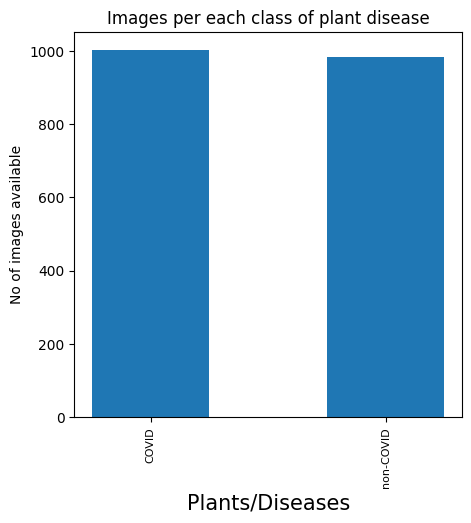

In [4]:
index = [n for n in range(len(diseases))]
plt.figure(figsize=(5, 5))
plt.bar(index, [n for n in nums.values()], width=0.5)
plt.xlabel('Plants/Diseases', fontsize=15)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=8, rotation=90)
plt.title('Images per each class of plant disease')

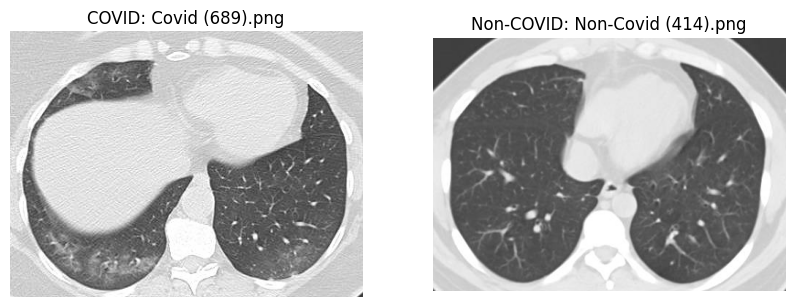

In [5]:
# Define the subdirectories
covid_dir = os.path.join(train_dir, "COVID")
non_covid_dir = os.path.join(train_dir, "non-COVID")

# Get all files in each subdirectory
covid_files = os.listdir(covid_dir)
non_covid_files = os.listdir(non_covid_dir)

# Filter out non-image files
image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
covid_images = [file for file in covid_files if file.lower().endswith(image_extensions)]
non_covid_images = [file for file in non_covid_files if file.lower().endswith(image_extensions)]

selected_covid_image = random.choice(covid_images)
selected_non_covid_image = random.choice(non_covid_images)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

covid_image_path = os.path.join(covid_dir, selected_covid_image)
covid_img = mpimg.imread(covid_image_path)
axes[0].imshow(covid_img)
axes[0].axis('off')  
axes[0].set_title(f"COVID: {selected_covid_image}")  

non_covid_image_path = os.path.join(non_covid_dir, selected_non_covid_image)
non_covid_img = mpimg.imread(non_covid_image_path)
axes[1].imshow(non_covid_img)
axes[1].axis('off')
axes[1].set_title(f"Non-COVID: {selected_non_covid_image}") 

plt.show()


In [6]:
batch_size = 12
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.Grayscale()
    ]),
    'Test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.Grayscale()
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['Train', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Test']}
class_names = image_datasets['Train'].classes
print(class_names)

['COVID', 'non-COVID']


Huấn luyện và kiểm thử mô hình

In [7]:
# Lựu chọn phần cứng sử dụng để tính toán
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in (range(num_epochs)):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['Train', 'Test']:
                if phase == 'Train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for idx, (inputs, labels) in enumerate(tqdm(dataloaders[phase], desc=f'{phase} phase')):
                    # Đẩy dữ liệu sang GPU
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    
                if phase == 'Train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                if phase == 'Train':    
                    writer_train.add_scalar('train loss',
                                epoch_loss,
                                epoch)
                    writer_train.add_scalar('train accuracy',
                                            epoch_acc,
                                            epoch)
                else:
                    writer_test.add_scalar('test loss',
                                epoch_loss,
                                epoch)
                    writer_test.add_scalar('test accuracy',
                                            epoch_acc,
                                            epoch)
                    
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                
                # deep copy the model
                if phase == 'Test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model



In [9]:
vgg = models.vgg19(weights='IMAGENET1K_V1')

vgg.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, 2048))

original_conv1 = vgg.features[0]
new_conv1 = nn.Conv2d(
    in_channels=1,  # 1 kênh cho ảnh grayscale
    out_channels=original_conv1.out_channels,
    kernel_size=original_conv1.kernel_size,
    stride=original_conv1.stride,
    padding=original_conv1.padding
)

with torch.no_grad():
    new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))
    new_conv1.bias = original_conv1.bias

vgg.features[0] = new_conv1

In [10]:
dataiter = iter(dataloaders["Train"])
images, labels = next(dataiter)

In [11]:
writer_train.add_graph(vgg, images)
writer_train.close()
vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
criterion = nn.CrossEntropyLoss() #hàm mất mát

optimizer_ft = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(vgg, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

In [ ]:
torch.save(model_ft.state_dict(),"models")